# Produce Cached `galaxy_ids` for DC2

_Last Updated: Bryce Kalmbach, September 2018_

This is a notebook to produce the cached AGN and SN galaxy_id lists for DC2 Run 2. In this notebook we match the source AGN and SNe galaxies to objects in the galaxy catalogs.

In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from desc.sims.GCRCatSimInterface import InstanceCatalogWriter
from lsst.sims.utils import SpecMap
import matplotlib.pyplot as plt
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, BandpassDict, Bandpass
from lsst.sims.catUtils.matchSED import matchBase
import os
import sqlite3
%matplotlib inline

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/global/homes/d/danielsf/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:555: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/global/homes/d/danielsf/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:555: UserWarning: Duplicate object type id 28 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## Point to locations for unlensed AGN and SNe information

Even if you already have an unsprinkled instance catalog ready you need to specify the locations of DC2 unlensed AGN and SNe databases. The AGN database is needed to know the AGN properties to sprinkle and the SNe database is needed to avoid sprinkling with galaxies that will have unlensed SNe at some point in the survey.

In [2]:
agnDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_db_mbh7_mi30_sf4.db'
sneDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sne_cosmoDC2_v1.1.4_MS_DDF.db'
assert os.path.isfile(agnDB)
assert os.path.isfile(sneDB)

### Create an unsprinkled Instance Catalog 

This is to get the possible AGN and Bulge galaxies to replace with the sprinkler. We use `cosmoDC2_v1.1.0_addon_knots`. Make sure to specify the correct database locations in the cell below.

In [3]:
# First we need to create a catalog without sprinkling
opsimDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
starDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/dc2_stellar_db.db'

In [4]:
t_sky = InstanceCatalogWriter(opsimDB, 'cosmoDC2_v1.1.4_image_addon_knots', min_mag=30, protoDC2_ra=0,
                              protoDC2_dec=0, sprinkler=False,
                              agn_db_name=agnDB, star_db_name=starDB,
                              sed_lookup_dir='/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup')

In [5]:
uddf_visit = 197356 # Use a visit we know covers the uDDF field
t_sky.write_catalog(uddf_visit, out_dir=os.environ['SCRATCH'], fov=1.5)

/global/homes/d/danielsf/sims_catUtils/python/lsst/sims/catUtils/mixins/VariabilityMixin.py:856: RuntimeWarning: divide by zero encountered in true_divide
  dd = _au_to_parsec/parallax


all done with 197356


### Load in the galaxy catalogs as dataframes

In [6]:
base_columns = ['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim',
                        'phosimMagNorm', 'sedFilepath', 'redshift',
                        'shear1', 'shear2', 'kappa', 'raOffset', 'decOffset',
                        'spatialmodel']

In [7]:
df_galaxy = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'bulge_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])

In [8]:
df_disk = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'disk_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])

In [9]:
df_agn = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'agn_gal_cat_197356.txt.gz'),
                                 delimiter=' ', header=None,
                                 names=base_columns+['internalExtinctionModel',
                                                     'galacticExtinctionModel',
                                                     'galacticAv', 'galacticRv'])

We calculate the `galaxy_id` for each catalog so that we can join them together and also save it in the cache for the sprinkler.

In [10]:
df_agn['galaxy_id'] = np.right_shift(df_agn['uniqueId'], 10)

In [11]:
df_agn.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,1344000087157,54.129332,-26.547373,20.715160,agnSED/agn.spec.gz,0.034863,-1.966811e-05,-0.000008,-0.000043,0,0,point,none,CCM,0.037487,3.1,1312500085
1,object,1344000093301,53.736770,-26.539267,20.598654,agnSED/agn.spec.gz,0.047179,-4.034774e-06,-0.000004,-0.000018,0,0,point,none,CCM,0.035472,3.1,1312500091
2,object,1344000118901,53.167155,-26.602102,23.968804,agnSED/agn.spec.gz,0.035631,8.140367e-07,0.000012,-0.000033,0,0,point,none,CCM,0.029849,3.1,1312500116
3,object,1344000122997,53.839760,-26.831988,22.260965,agnSED/agn.spec.gz,0.041929,-2.322976e-05,-0.000004,-0.000053,0,0,point,none,CCM,0.035422,3.1,1312500120
4,object,1344000579701,52.982573,-26.272642,22.113472,agnSED/agn.spec.gz,0.069013,2.388888e-04,-0.000159,-0.000136,0,0,point,none,CCM,0.034013,3.1,1312500566


In [12]:
df_galaxy['galaxy_id'] = np.right_shift(df_galaxy['uniqueId'], 10)

In [13]:
df_galaxy.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,1344000063585,52.871940,-26.612869,21.891768,galaxySED/Inst.40E09.002Z.spec.gz,0.040747,-3.637350e-06,7.870029e-06,-0.000034,...,0.399131,102.888481,4,CCM,0.0,2.0,CCM,0.032753,3.1,1312500062
1,object,1344000064609,53.524389,-26.777568,19.464167,galaxySED/Exp.50E09.04Z.spec.gz,0.047217,6.460591e-07,2.487866e-06,-0.000014,...,2.027042,51.359441,4,CCM,0.1,4.0,CCM,0.027568,3.1,1312500063
2,object,1344000065633,52.856460,-26.529207,19.979710,galaxySED/Burst.50E09.0005Z.spec.gz,0.039386,3.550765e-06,9.230252e-07,-0.000011,...,0.636589,45.145847,4,CCM,0.1,3.2,CCM,0.044842,3.1,1312500064
3,object,1344000066657,53.141430,-26.219154,19.789442,galaxySED/Inst.50E08.25Z.spec.gz,0.047168,-1.070414e-05,-1.294571e-05,-0.000017,...,0.979636,89.408847,4,CCM,0.0,2.0,CCM,0.034134,3.1,1312500065
4,object,1344000082017,53.747638,-26.303373,19.744180,galaxySED/Inst.16E09.04Z.spec.gz,0.041702,-1.047741e-05,1.404744e-05,-0.000029,...,0.810064,94.870050,4,CCM,0.0,2.0,CCM,0.033553,3.1,1312500080


In [14]:
df_disk['galaxy_id'] = np.right_shift(df_disk['uniqueId'], 10)

In [15]:
df_disk.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,1344000063595,52.871940,-26.612869,21.436947,galaxySED/Burst.12E09.02Z.spec.gz,0.040747,-3.637350e-06,7.870029e-06,-0.000034,...,0.336616,102.888481,1,CCM,0.1,2.9,CCM,0.032753,3.1,1312500062
1,object,1344000064619,53.524389,-26.777568,19.135369,galaxySED/Const.12E10.1Z.spec.gz,0.047217,6.460591e-07,2.487866e-06,-0.000014,...,2.320681,51.359441,1,CCM,0.6,4.0,CCM,0.027568,3.1,1312500063
2,object,1344000065643,52.856460,-26.529207,20.269053,galaxySED/Exp.32E09.0005Z.spec.gz,0.039386,3.550765e-06,9.230252e-07,-0.000011,...,0.377544,45.145847,1,CCM,0.1,2.0,CCM,0.044842,3.1,1312500064
3,object,1344000066667,53.141430,-26.219154,20.026764,galaxySED/Inst.12E09.0005Z.spec.gz,0.047168,-1.070414e-05,-1.294571e-05,-0.000017,...,1.710494,89.408847,1,CCM,0.0,2.0,CCM,0.034134,3.1,1312500065
4,object,1344000072811,53.255325,-27.066992,19.076449,galaxySED/Const.10E10.02Z.spec.gz,0.046909,-1.844177e-05,-4.740302e-06,-0.000045,...,0.729402,153.561163,1,CCM,0.4,4.0,CCM,0.028639,3.1,1312500071


### Match the AGN catalog to Twinkles systems

We will go through the AGN catalog and find AGN in the uDDF field that match our properties. We will then save the `galaxy_id` of these AGN and give the corresponding OM10 system a `twinklesId` in the catalog that identifies it with this AGN when the sprinkler runs.

In [16]:
# Load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../../data/twinkles_lenses_cosmoDC2_v1.1.4.fits')
twinkles_lenses = hdulist[1].data

In [17]:
# Convert phosimMagNorm to i-band magnitudes for the uDDF AGN
bpDict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames=['i'])
bp = Bandpass()
imsimBand = bp.imsimBandpass()
agn_fname = str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz')

src_iband = []
src_mag_norm = df_agn['phosimMagNorm'].values
src_z = df_agn['redshift'].values

for src_mag, s_z in zip(src_mag_norm, src_z):
    agn_sed = Sed()
    agn_sed.readSED_flambda(agn_fname)
    agn_sed.redshiftSED(s_z, dimming=True)
    f_norm = agn_sed.calcFluxNorm(src_mag, bp)
    agn_sed.multiplyFluxNorm(f_norm)
    src_iband.append(agn_sed.calcMag(bpDict['i']))

In [18]:
df_agn['i_magnitude'] = src_iband

We want to match the AGN in the uDDF field to lensed systems based upon the redshift and magnitude of the source AGN. In this example we use 0.1 dex in redshift and 0.25 mags in the _i_-band. **(Anytime you use a new catalog this may need to be played with to get the desired number of systems)**

In [19]:
def find_agn_lens_candidates(galz, gal_mag):
        # search the OM10 catalog for all sources +- 0.1 dex in redshift                                                                                               
        # and within .25 mags of the AGN source                                                                                                                     
    w = np.where((np.abs(np.log10(twinkles_lenses['ZSRC']) - np.log10(galz)) <= 0.1) &
                     (np.abs(twinkles_lenses['MAGI_IN'] - gal_mag) <= .25))[0]
    lens_candidates = twinkles_lenses[w]

    return lens_candidates

In [20]:
# Only search within the DDF field
df_agn = df_agn.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')
df_galaxy = df_galaxy.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')
df_disk = df_disk.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')

In [21]:
df_agn = df_agn.reset_index(drop=True)
df_galaxy = df_galaxy.reset_index(drop=True)
df_disk = df_disk.reset_index(drop=True)

#### Avoid galaxies with unlensed SNe.

First load up cached `galaxy_ids` and then to speed things up when comparing to possible sprinkled ids we use database merges to only find the ones that are in the uddf field.

In [22]:
conn = sqlite3.connect(sneDB) 

In [23]:
sne_query = conn.cursor()

In [24]:
sne_unsprinkled_galids = sne_query.execute('select galaxy_id from sne_params').fetchall()

In [25]:
sne_unsprinkled_galids = np.array(sne_unsprinkled_galids).flatten()

In [26]:
ddf_galids = pd.DataFrame(df_agn['galaxy_id'])

In [27]:
ddf_galids = ddf_galids.merge(pd.DataFrame(df_galaxy['galaxy_id']), how='outer', on='galaxy_id')

In [28]:
ddf_galids = ddf_galids.merge(pd.DataFrame(df_disk['galaxy_id']), how='outer', on='galaxy_id')

In [29]:
sne_avoid_galids = ddf_galids.merge(pd.DataFrame(sne_unsprinkled_galids, columns=['galaxy_id']), how='inner', on='galaxy_id')

In [30]:
sne_avoid_galids = sne_avoid_galids.values

#### Sprinkle in the AGN

In [31]:
%%time
density_param = 0.08
good_rows = []
ra_list = []
dec_list = []
gal_ids = []
catalog_row_num = []
catalog_ids = []

for row_idx in range(len(df_agn)):
    
    row = df_agn.iloc[row_idx]

    if row_idx % 5000 == 0:
        print(row_idx, len(catalog_ids))
        
    if row.galaxy_id in sne_avoid_galids:
        continue

    if row.galaxy_id > 0:
        candidates = find_agn_lens_candidates(row.redshift, row.i_magnitude)
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        if len(candidates) > 0:
            for candidate_idx, candidate_sys in list(enumerate(candidates['LENSID'])):
                if candidate_sys not in catalog_ids:
                    keep_idx.append(candidate_idx)
            if len(keep_idx) == 0:
                continue
            else:
                candidates = candidates[keep_idx]
        pick_value = np.random.uniform()
        if ((len(candidates) > 0) and (pick_value <= density_param)):
            good_rows.append(row_idx)
            gal_ids.append(row.galaxy_id)
            newlens = np.random.choice(candidates)
            catalog_ids.append(newlens['LENSID'])
            catalog_row_num.append(np.where(twinkles_lenses['LENSID'] == newlens['LENSID'])[0][0])
            ra_list.append(row.raPhoSim)
            dec_list.append(row.decPhoSim)
            #print(len(catalog_ids))

0 0


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


5000 28
10000 77
15000 131
20000 188
25000 259
30000 326
35000 423
40000 505
45000 587
50000 668
55000 722
60000 803
65000 888
70000 913
75000 962
CPU times: user 17min 11s, sys: 2.41 s, total: 17min 14s
Wall time: 17min 14s


In [32]:
print(len(catalog_ids))

991


In [33]:
len(good_rows), len(np.unique(good_rows)), len(np.unique(catalog_ids)), len(np.unique(catalog_row_num))

(991, 991, 991, 991)

In [34]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

Check to see that our cached systems are distributed throughout the uDDF field.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


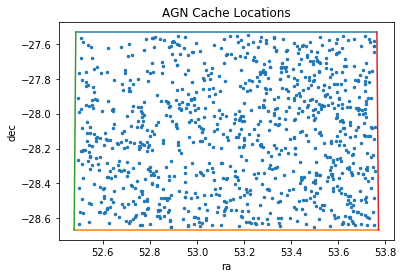

In [35]:
plt.scatter(ra_list, dec_list, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel(r'ra')
plt.ylabel(r'dec')
plt.title('AGN Cache Locations')
#plt.savefig('agn_cache.png')

In [36]:
#this is where scott first ran up to

catalog_row_sort = np.argsort(catalog_row_num)
catalog_row_num = np.array(catalog_row_num)

In [37]:
print(twinkles_lenses.columns)

ColDefs(
    name = 'LENSID'; format = 'J'
    name = 'FLAGTYPE'; format = 'I'
    name = 'NIMG'; format = 'I'
    name = 'ZLENS'; format = 'D'
    name = 'VELDISP'; format = 'D'
    name = 'ELLIP'; format = 'D'
    name = 'PHIE'; format = 'D'
    name = 'GAMMA'; format = 'D'
    name = 'PHIG'; format = 'D'
    name = 'ZSRC'; format = 'D'
    name = 'XSRC'; format = 'D'
    name = 'YSRC'; format = 'D'
    name = 'MAGI_IN'; format = 'D'
    name = 'MAGI'; format = 'D'
    name = 'IMSEP'; format = 'D'
    name = 'XIMG'; format = '4D'
    name = 'YIMG'; format = '4D'
    name = 'MAG'; format = '4D'
    name = 'DELAY'; format = '4D'
    name = 'KAPPA'; format = '4D'
    name = 'FSTAR'; format = '4D'
    name = 'DD'; format = 'D'
    name = 'DDLUM'; format = 'D'
    name = 'ABMAG_I'; format = 'D'
    name = 'APMAG_I'; format = 'D'
    name = 'KCORR'; format = 'D'
    name = 'DS'; format = 'D'
    name = 'DDS'; format = 'D'
    name = 'SIGCRIT'; format = 'D'
    name = 'DSLUM'; format = 'D'


In [42]:
# Add in Twinkles ID Number to catalog for matched objects
col_list = []
for col in twinkles_lenses.columns:
        col_format = col.format
        if col.name == 'lens_sed':
            col_format = '40A'
        col_list.append(fits.Column(name=col.name, format=col_format, array=twinkles_lenses[col.name][catalog_row_num[catalog_row_sort]]))
col_list.append(fits.Column(name='twinklesId', format='I', array=np.arange(len(good_rows))))

In [43]:
col_list

[name = 'LENSID'; format = 'J',
 name = 'FLAGTYPE'; format = 'I',
 name = 'NIMG'; format = 'I',
 name = 'ZLENS'; format = 'D',
 name = 'VELDISP'; format = 'D',
 name = 'ELLIP'; format = 'D',
 name = 'PHIE'; format = 'D',
 name = 'GAMMA'; format = 'D',
 name = 'PHIG'; format = 'D',
 name = 'ZSRC'; format = 'D',
 name = 'XSRC'; format = 'D',
 name = 'YSRC'; format = 'D',
 name = 'MAGI_IN'; format = 'D',
 name = 'MAGI'; format = 'D',
 name = 'IMSEP'; format = 'D',
 name = 'XIMG'; format = '4D',
 name = 'YIMG'; format = '4D',
 name = 'MAG'; format = '4D',
 name = 'DELAY'; format = '4D',
 name = 'KAPPA'; format = '4D',
 name = 'FSTAR'; format = '4D',
 name = 'DD'; format = 'D',
 name = 'DDLUM'; format = 'D',
 name = 'ABMAG_I'; format = 'D',
 name = 'APMAG_I'; format = 'D',
 name = 'KCORR'; format = 'D',
 name = 'DS'; format = 'D',
 name = 'DDS'; format = 'D',
 name = 'SIGCRIT'; format = 'D',
 name = 'DSLUM'; format = 'D',
 name = 'L_I'; format = 'D',
 name = 'REFF'; format = 'D',
 name = 'R

Save this catalog of only the systems we need.

In [44]:
cols = fits.ColDefs(col_list)
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('../../data/cosmoDC2_v1.1.4_matched_AGN.fits')

In [45]:
tbhdu.data[:5]

FITS_rec([ (431864, 0, 2,  0.2  ,  205.1162,  0.2784123 ,  -39.1588 ,  0.05159786,   75.38537,  2.16,  0.1176923 , -0.06849588,  24.49,  22.90721,  1.882717, [ 0.8468, -0.8855,  0.    ,  0.    ], [-0.8346, -0.0972,  0.    ,  0.    ], [ 4.2965, -5.3298,  0.    ,  0.    ], [  0.   ,   8.204,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  680.579895,   980.035156, -22.3044796,  17.8517303,  0.2       ,  1709.61,  1451.17 ,  0.,  17071.5 ,  0.,  2.04867339,  0., 'galaxySED/Exp.50E09.1Z.spec.gz',  18.49433104, 0),
          (446063, 0, 2,  0.202,  263.0268,  0.06264275,  -46.85597,  0.04434961,  114.9769 ,  1.25,  0.2783159 ,  0.4742334 ,  23.23,  22.79915,  3.094686, [-0.5863,  0.6371,  0.    ,  0.    ], [-0.8146,  2.028 ,  0.    ,  0.    ], [-1.4871,  4.1535,  0.    ,  0.    ], [ 49.484,   0.   ,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  685.897339,   990.987244, -22.9583015,  17.2240372,  0.20200001,  1720.14,  1353.71 ,  0.,   8708.21,  0.,  2.0080

Save the cached `galaxy_id` info to file

In [46]:
agn_cache = pd.DataFrame(np.array([np.array(gal_ids)[catalog_row_sort], np.arange(len(good_rows))], dtype=np.int).T,
                         columns=['galtileid', 'twinkles_system'])

In [47]:
agn_cache.head()

,galtileid,twinkles_system
0,2570959574,0
1,2567306461,1
2,2576173859,2
3,2566168960,3
4,2563255171,4


In [48]:
agn_cache.tail()

,galtileid,twinkles_system
986,2567258264,986
987,2567645011,987
988,2569857679,988
989,2579224734,989
990,2577934627,990


In [49]:
#Check that galaxy_ids and twinkles_ids in FITS match up after sort
g_id = np.where(np.array(gal_ids) == agn_cache['galtileid'].values[0])
print(np.array(catalog_ids)[g_id] == tbhdu.data['LENSID'][0])

[ True]


In [50]:
agn_cache.to_csv('cosmoDC2_v1.1.4_agn_cache.csv', index=False)

### Match to GLSNe catalog

Here we do the same as we did for the AGN and OM10 catalog except with a bulge+disk galaxy catalog and the host galaxy information from the Gravitationally Lensed SNe catalog.

We begin by loading the hdf5 tables for the lensed SNe catalog into dataframes.

In [51]:
sne_systems = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='system')
sne_images = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='image')

In [52]:
use_gals_df = df_galaxy.query('raPhoSim > 52.495 and raPhoSim < 53.755 and decPhoSim > -28.65 and decPhoSim < -27.55')

In [53]:
len(use_gals_df)

1799129

In [54]:
use_gals_df = use_gals_df.merge(df_disk, on='galaxy_id', suffixes=('_bulge', '_disk'))

Following from Table 3 in Mannucci et al. 2005 (https://www.aanda.org/articles/aa/pdf/2005/15/aa1411.pdf) we are going to use galaxy colors
to scale the sn rate by color as a proxy for galaxy type, but we end up changing it from that a bit to give us good sample sizes of all types in the DDF region.

In [55]:
from lsst.utils import getPackageDir

In [56]:
sims_sed_list = os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                        'galaxySED'))

In [57]:
sims_sed_dict = {}
for sed_name in sims_sed_list:
    sed_obj = Sed()
    sed_obj.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                         'galaxySED', sed_name))
    sims_sed_dict[os.path.join('galaxySED', sed_name)] = sed_obj

In [58]:
# Filters from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
bp_B = Bandpass(wavelen_max = 2700.)
bp_B.setBandpass(wavelen=np.array([360., 380., 400., 420., 460., 480.,
                                   500., 520., 540., 560.]),
                 sb=np.array([0.00, 0.11, 0.92, 0.94, 0.79, 0.58,
                              0.36, 0.15, 0.04, 0.0]))
bp_K = Bandpass(wavelen_max = 2700.)
bp_K.setBandpass(wavelen=np.linspace(1800., 2600., 17),
                 sb=np.array([0.00, 0.10, 0.48, 0.95, 1.00, 0.98,
                              0.96, 0.95, 0.97, 0.96, 0.94, 0.95,
                              0.95, 0.84, 0.46, 0.08, 0.00]))
bp_dict = BandpassDict(bandpassNameList=['B', 'K'], bandpassList=[bp_B, bp_K])

In [59]:
from lsst.sims.photUtils import getImsimFluxNorm
from copy import deepcopy
bk_color = []
i = 0
for sed_name_bulge, redshift, magNorm_bulge, sed_name_disk, magNorm_disk in zip(use_gals_df['sedFilepath_bulge'].values,
                                                                                use_gals_df['redshift_bulge'].values,
                                                                                use_gals_df['phosimMagNorm_bulge'].values,
                                                                                use_gals_df['sedFilepath_disk'].values,
                                                                                use_gals_df['phosimMagNorm_disk'].values):
    if i % 100000 == 0:
        print(i)

    sed_obj_bulge = deepcopy(sims_sed_dict[sed_name_bulge])
    f_norm_b = getImsimFluxNorm(sed_obj_bulge, magNorm_bulge)
    sed_obj_bulge.multiplyFluxNorm(f_norm_b)
    sed_obj_bulge.redshiftSED(redshift)
    
    sed_obj_disk = deepcopy(sims_sed_dict[sed_name_disk])
    f_norm_d = getImsimFluxNorm(sed_obj_disk, magNorm_disk)
    sed_obj_disk.multiplyFluxNorm(f_norm_d)
    sed_obj_disk.redshiftSED(redshift)
    
    sed_obj = Sed()
    sed_obj.setSED(wavelen=sed_obj_bulge.wavelen, flambda=sed_obj_bulge.flambda+sed_obj_disk.flambda)
    
    
    b_val, k_val = bp_dict.magListForSed(sed_obj)
    bk_color.append(b_val - k_val)
    i+=1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [60]:
bk_color = np.array(bk_color)

In [61]:
# Save so if kernel resets we don't have to do it again.
np.savetxt('bk_color.dat', bk_color)

In [62]:
# Uncomment to load from file
#bk_color = np.genfromtxt('bk_color.dat')

In [63]:
use_gals_df['bk_color'] = bk_color

In [64]:
use_gals_df = use_gals_df.reset_index(drop=True)

As we did before we match based upon a property in each catalog. Here we use the source redshift of the SNe in the lens catalog and the redshift of the potential host galaxies in the uDDF field. Since we have so many potential host galaxies we tighten up the redshift bounds to 0.01 in dex. We also use the galaxy type from the colors to associate to proper types of host galaxies in the lensed SNe catalog.

In [65]:
def find_sne_lens_candidates(galz, gal_type):#, gal_mag):
    # search the galaxy catalog for all possible host galaxies +- 0.05 dex in redshift

    lens_candidates = sne_systems.query(str('zs < {}'.format(np.power(10, np.log10(galz)+0.01)) + ' and ' +
                                            'zs > {}'.format(np.power(10, np.log10(galz)-0.01))))
        
    if gal_type == 't1':
        lens_candidates = lens_candidates.query('host_type == "kinney-starburst"')
    elif gal_type == 't4':
        lens_candidates = lens_candidates.query('host_type == "kinney-elliptical"')
    else:
        lens_candidates = lens_candidates.query('host_type == "kinney-sc"')

    return lens_candidates

In [66]:
#%%time
density_param = .0005
good_rows_sn = []
gal_ids_sn = []
sys_ids_sn = []
used_systems = []
ra_list_sn = []
dec_list_sn = []
type_sn = []
redshift_sn = []

rd_state = np.random.RandomState(47)

for row_idx in range(len(use_gals_df)):
    
    density_test = rd_state.uniform()
    
    gal_bk = use_gals_df['bk_color'].iloc[row_idx]
    
    if gal_bk < 2.6:
        type_density_param = 1.2*density_param
        gal_type = 't1'
    elif ((2.6 <= gal_bk) and (gal_bk < 3.3)):
        type_density_param = 3.*density_param
        gal_type = 't2'
    elif ((3.3 <= gal_bk) and (gal_bk < 4.1)):
        type_density_param = 2.*density_param
        gal_type = 't3'
    else:
        type_density_param = 3.*density_param
        gal_type = 't4'
    
    if density_test > type_density_param:
        continue
    
    row = use_gals_df.iloc[row_idx]
    
    gal_id = use_gals_df['galaxy_id'].iloc[row_idx]
    if gal_id in df_agn['galaxy_id'].values:
        continue
    elif gal_id in sne_avoid_galids:
        continue
    
    if len(good_rows_sn) % 50 == 0:
        print(row_idx, len(good_rows_sn))

    if row.galaxy_id > 0:
        #print(gal_type)
        candidates = find_sne_lens_candidates(row.redshift_bulge, gal_type)
        #print(len(candidates))
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        for candidate_idx in range(len(candidates)):
            if candidates.index[candidate_idx] in used_systems:
                continue
            else:
                keep_idx.append(candidate_idx)
        candidates = candidates.iloc[keep_idx]

        if len(candidates) > 0:
            choice = np.random.choice(np.arange(len(candidates)), p=candidates['weight']/np.sum(candidates['weight']))
            used_systems.append(candidates.index[choice])
            newlens = candidates.iloc[choice]
            #print(len(catalog_ids))
            sys_ids_sn.append(newlens.sysno)
            gal_ids_sn.append(row.galaxy_id)
            ra_list_sn.append(row.raPhoSim_bulge)
            dec_list_sn.append(row.decPhoSim_bulge)
            good_rows_sn.append(row_idx)
            type_sn.append(gal_type)
            redshift_sn.append(row.redshift_bulge)

271 0
72897 50
132954 100
189460 150
260983 200
336047 250
407645 300
463420 350
539579 400
611656 450
689162 500
779432 550
855267 600
950664 650
1043958 700
1547433 750
1619232 800
1717832 850
1721333 850
1721950 850
1722291 850
1726210 850
1727534 850
1728816 850
1730012 850
1732389 850
1732445 850
1734246 850
1735636 850
1735914 850
1738488 850
1741608 850
1744195 850
1745009 850
1746916 850
1749538 850
1749761 850
1754285 850
1761807 850
1764246 850
1764837 850
1765968 850
1766497 850
1769049 850
1769729 850
1770494 850
1771050 850
1772099 850
1772416 850
1776306 850
1777550 850
1778351 850
1778821 850
1780062 850
1780576 850
1784765 850
1787179 850
1788966 850
1789552 850
1789624 850
1790573 850
1793063 850
1793597 850
1793674 850
1794869 850


In [67]:
len(good_rows_sn), len(ra_list_sn)

(850, 850)

In [68]:
print(len(np.where(np.array(type_sn) == "t1")[0]))
print(len(np.where(np.array(type_sn) == "t2")[0]))
print(len(np.where(np.array(type_sn) == "t3")[0]))
print(len(np.where(np.array(type_sn) == "t4")[0]))

579
138
82
51


Once again check to see that we are spread throught uDDF region.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


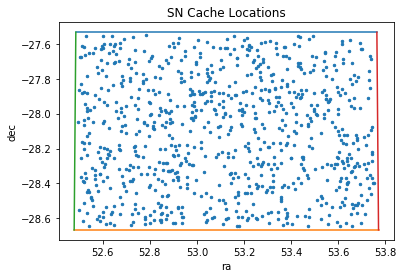

In [69]:
plt.scatter(ra_list_sn, dec_list_sn, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('SN Cache Locations')
#plt.savefig('sne_cache.png')

Now we need to join the information in the systems and image dataframes and then save only the ones we are using to file.

In [70]:
keep_systems = sne_systems.iloc[used_systems]

In [71]:
keep_systems['twinkles_sysno'] = np.arange(len(keep_systems)) + 1100

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [72]:
keep_catalog = keep_systems.merge(sne_images, on='sysno')

In [73]:
t_start = keep_catalog['t0'] + keep_catalog['td']

In [74]:
keep_catalog['t_start'] = t_start

In [75]:
keep_catalog.to_csv('cosmoDC2_v1.1.4_sne_cat.csv', index=False)

Save the cache of `galaxy_ids` and associated `twinklesId` values to file.

In [76]:
sne_cache = pd.DataFrame(np.array([gal_ids_sn, np.arange(len(keep_systems)) + 1100], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [77]:
sne_cache.to_csv('cosmoDC2_v1.1.4_sne_cache.csv', index=False)

### Check that `galaxy_ids` will not clash when the sprinkler modifies them

We need to make sure that we can adjust the `galaxy_id` values of the sprinkler galaxies so that we can record information in the id values, but we need to make sure the new id values don't clash with `cosmoDC2` id values. We check that below.

In [78]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [79]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [80]:
cosmo_ids = catalog.get_quantities(['galaxy_id'])

In [81]:
smallest_id = np.min(cosmo_ids['galaxy_id'])
largest_id = np.max(cosmo_ids['galaxy_id'])

In [82]:
print(largest_id, smallest_id)

12083345922 1250000000


The highest `galaxy_id` in `cosmoDC2_v1.0_image` is ~1.44e10. Therefore, if we add 1.5e10 to all `galaxy_id` values that are sprinkled then we will be above this. After that we multiply by 10000 to get room to add in the twinkles system numbers in the last 4 digits. If these numbers are less that 2^63 then we will be ok when generating instance catalogs.

In [83]:
offset = np.int(1.5e10)

In [84]:
(2**63) - np.left_shift((largest_id + offset)*10000, 10)

8.9460385746134958e+18

We are under the 2^63 limit. So, we can use this scheme to make sure there are no id clashes and add in the twinkles information as before.